In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

from envs.environments import NeuralNetwork

pygame 2.5.2 (SDL 2.28.3, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
def transition_generator(maze, with_walls = True):
    transiciones = []

    n_rows, n_cols = len(maze), len(maze[0])

    for y in range(n_rows):
        for x in range(n_cols):
            # Si la casilla actual es un muro, no se puede guardar la transición
            if maze[y][x] != '#':
                for a in range(4):
                    if a == 0:  # Mover hacia el norte
                        y1, x1 = max(0, y - 1), x
                    elif a == 1:  # Mover hacia el sur
                        y1, x1 = min(n_rows - 1, y + 1), x
                    elif a == 2:  # Mover hacia el oeste
                        y1, x1 = y, max(0, x - 1)
                    elif a == 3:  # Mover hacia el este
                        y1, x1 = y, min(n_cols - 1, x + 1)

                    # Verificamos si la casilla siguiente es un muro
                    if maze[y1][x1] != '#':
                        transiciones.append([y, x, a, y1, x1])
                    else:
                        # Si la casilla siguiente es un muro, se debe guardar la transición de la casilla actual a sí misma
                        if with_walls:
                            transiciones.append([y, x, a, y, x])

    return transiciones

def transitions_families_generator(transiciones_iniciales, porcentaje_retencion, n):
    n_transiciones_iniciales = len(transiciones_iniciales)
    m = int((1 - porcentaje_retencion) * n_transiciones_iniciales)

    nuevos_arrays = []

    for _ in range(n):
        # Crear una copia de las transiciones iniciales
        nuevas_transiciones = transiciones_iniciales.copy()

        # Eliminar aleatoriamente M transiciones
        transiciones_a_eliminar = random.sample(nuevas_transiciones, m)
        for t in transiciones_a_eliminar:
            nuevas_transiciones.remove(t)

        nuevos_arrays.append(nuevas_transiciones)

    return nuevos_arrays

In [3]:
class FamiliaTransiciones:
    def __init__(self, shape, T):
        self.shape = shape

        self.T = T
        
        self.sy_values = np.array([], dtype = np.float32)
        self.sx_values = np.array([], dtype = np.float32)
        self.a_values = np.array([], dtype = np.float32)
        self.sy1_values = np.array([], dtype = np.float32)
        self.sx1_values = np.array([], dtype = np.float32)

        self.input_data = None
        self.target_data = None

        self.X_train_tensor = None
        self.X_test_tensor = None
        self.y_train_tensor = None
        self.y_test_tensor = None

        if shape == "5x5":
            self.model = NeuralNetwork(3, 2)
            self.n_epochs = 5000
        elif shape == "14x14":
            self.model = NeuralNetwork(3, 2, 128, 64)
            self.n_epochs = 10000
        
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters())
        self.losses = []

        self.generate_arrays()
    

    def generate_arrays(self):
        for t in self.T:
            self.sy_values = np.append(self.sy_values, t[0])
            self.sx_values = np.append(self.sx_values, t[1])
            self.a_values = np.append(self.a_values, t[2])
            self.sy1_values = np.append(self.sy1_values, t[3])
            self.sx1_values = np.append(self.sx1_values, t[4])

        self.input_data = np.column_stack((self.sy_values, self.sx_values, self.a_values))
        self.target_data = np.column_stack((self.sy1_values, self.sx1_values))

    def train(self):
        X_train, X_test, y_train, y_test = train_test_split(self.input_data, self.target_data, test_size=0.2)
        
        self.X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        self.y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        self.X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        self.y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

        for _ in range(self.n_epochs):
            # Forward pass
            outputs = self.model(self.X_train_tensor)
            loss = self.criterion(outputs, self.y_train_tensor)
            
            # Backpropagation and optimization
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            self.losses.append(loss.item())
        
        print("Trained successfully!")
        print(f'Final loss: {self.losses[-1]}\n')

    def test_loss(self):
        with torch.no_grad():
            test_outputs = self.model(self.X_test_tensor)
            test_loss = self.criterion(test_outputs, self.y_test_tensor)
            print(f'Test loss: {test_loss.item()}')

    def show_loss(self):
        plt.xlabel("# Epoch")
        plt.ylabel("Loss Magnitude")
        plt.plot(self.losses)
        plt.show()

In [4]:
maze5x5 = { "starting_pos": [[0,0], [2,0], [4,0]],
             "maze":[
                    ['.', '.', '#', '.', 'G'],
                    ['.', '.', '#', '.', '.'],
                    ['.', '.', '.', '.', '.'],
                    ['.', '.', '#', '.', '.'],
                    ['S', '.', '#', '.', '.'],
                    ]
        }

maze14x14 = { "starting_pos": [[0,0], [5,0], [7,0], [13,0], [13,5], [13,8], [13,11]],
             "maze":[
                    ['.', '#', '.', '.', '.', '.', '.', '.', '#', '#', '#', '#', '.', 'G'],
                    ['.', '#', '.', '#', '#', '#', '.', '.', '.', '.', '.', '.', '.', '.'],
                    ['.', '.', '.', '.', '.', '#', '.', '.', '#', '.', '.', '#', '.', '.'],
                    ['.', '#', '#', '#', '.', '#', '.', '.', '.', '.', '.', '#', '.', '.'],
                    ['.', '.', '#', '.', '.', '#', '#', '#', '#', '#', '.', '#', '#', '.'],
                    ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '#', '.'],
                    ['#', '#', '#', '#', '#', '.', '#', '#', '.', '.', '.', '.', '#', '.'],
                    ['.', '.', '.', '.', '#', '.', '.', '#', '.', '.', '.', '.', '.', '.'],
                    ['.', '.', '.', '.', '#', '.', '.', '#', '.', '#', '.', '#', '#', '#'],
                    ['#', '.', '#', '.', '#', '.', '#', '#', '.', '#', '.', '.', '.', '.'],
                    ['.', '.', '#', '.', '.', '.', '#', '.', '.', '.', '.', '.', '.', '.'],
                    ['.', '#', '#', '.', '#', '.', '.', '.', '.', '#', '.', '#', '#', '.'],
                    ['.', '.', '.', '.', '#', '#', '.', '#', '.', '#', '.', '.', '#', '.'],
                    ['S', '.', '#', '.', '#', '.', '.', '#', '.', '#', '.', '.', '#', '.'],
                    ]
            }

In [5]:
shape = "5x5"

if shape == "5x5":
    maze = maze5x5["maze"]
    start_positions = maze5x5["starting_pos"]
else:
    maze = maze14x14["maze"]
    start_positions = maze14x14["starting_pos"]

In [6]:
all_transitions = transition_generator(maze)

# Imprimir algunas transiciones como ejemplo
#for i in range(len(all_transitions)):
    #print(all_transitions[i])

keep = 0.33  # Retener un % de las transiciones (0 a 1)

#Este siguiente parámetro debe ser impar para que nunca queden posibilidades equitativas
n = 9  # Generar N nuevos arrays

new_transitions = transitions_families_generator(all_transitions, keep, n)

#print("Long. del array original:", len(all_transitions))

#for transitions in new_transitions:
    #print("Long. de nuevo array", len(transitions))
    #for i in range(5):
        #print(transitions[i])
    #print("-"*17)

In [7]:
families_arr = []

for T in new_transitions:
    families_arr.append(FamiliaTransiciones(shape, T))

"""for f in families_arr:
    print("sy_values: ", f.sy_values)
    print("sx_values: ", f.sx_values)
    print("a_values:  ", f.a_values)
    print("sy1_values:", f.sy1_values)
    print("sx1_values:", f.sx1_values)
    print("-" * 50 + "\n")"""

'for f in families_arr:\n    print("sy_values: ", f.sy_values)\n    print("sx_values: ", f.sx_values)\n    print("a_values:  ", f.a_values)\n    print("sy1_values:", f.sy1_values)\n    print("sx1_values:", f.sx1_values)\n    print("-" * 50 + "\n")'

In [8]:
for f in families_arr:
    f.train()

Trained successfully!
Final loss: 0.0003376211388967931

Trained successfully!
Final loss: 1.1196947724556594e-07

Trained successfully!
Final loss: 0.00013705262972507626

Trained successfully!
Final loss: 1.1538817261680379e-06

Trained successfully!
Final loss: 5.0210066547151655e-05

Trained successfully!
Final loss: 0.0023816393222659826

Trained successfully!
Final loss: 0.00022704248840454966

Trained successfully!
Final loss: 3.339026807225309e-05

Trained successfully!
Final loss: 5.866733772563748e-06



Test loss: 0.36763259768486023


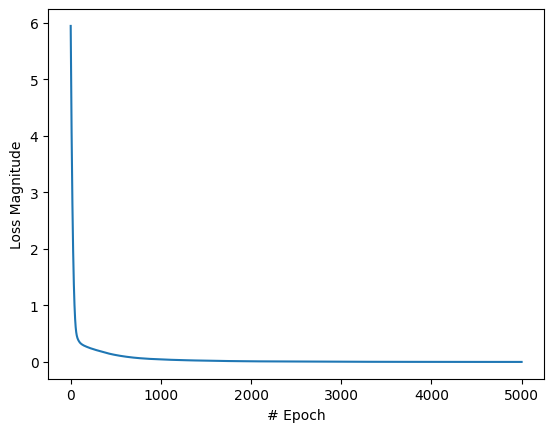

Test loss: 0.4980984628200531


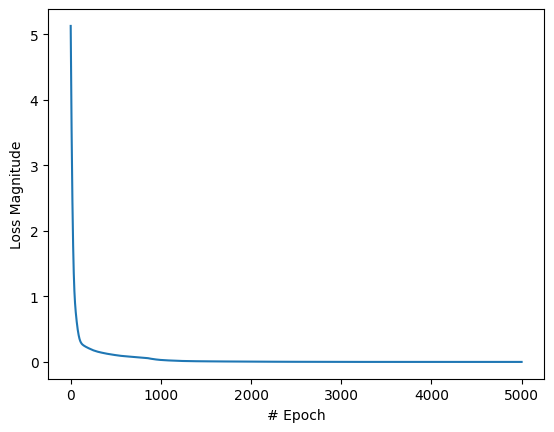

Test loss: 0.45435771346092224


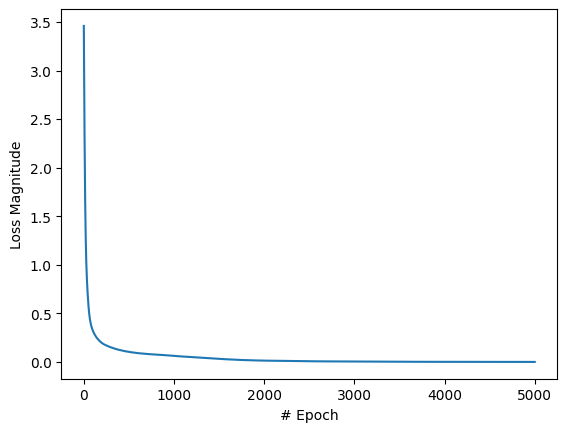

Test loss: 0.36625799536705017


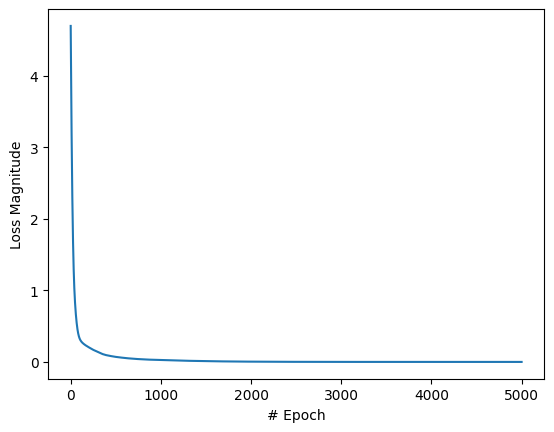

Test loss: 0.20540203154087067


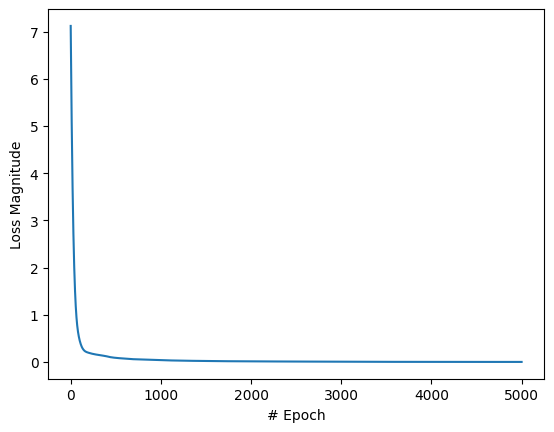

Test loss: 2.0021684169769287


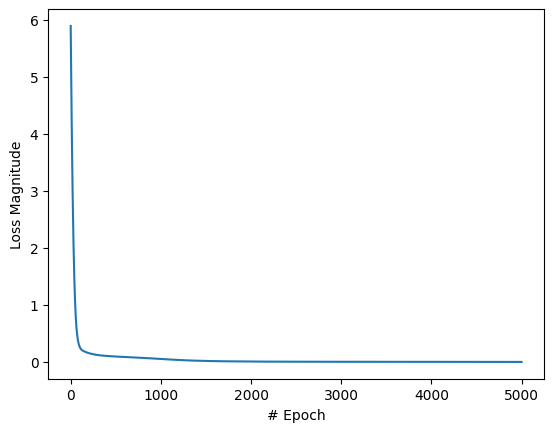

Test loss: 0.22441251575946808


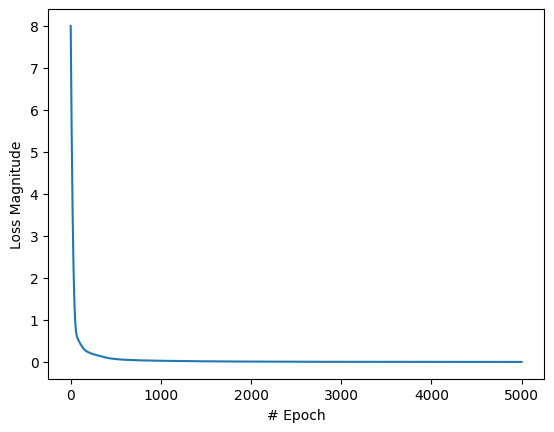

Test loss: 0.35885679721832275


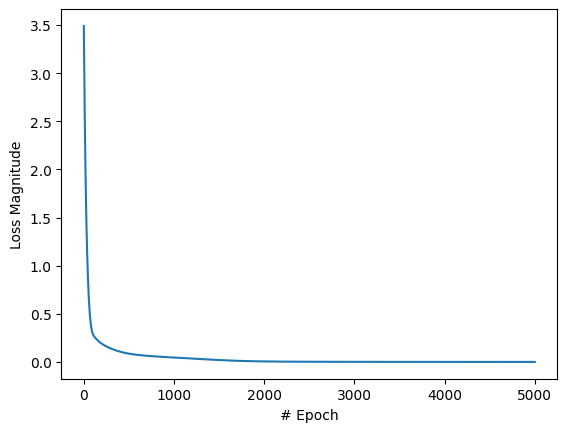

Test loss: 0.33915331959724426


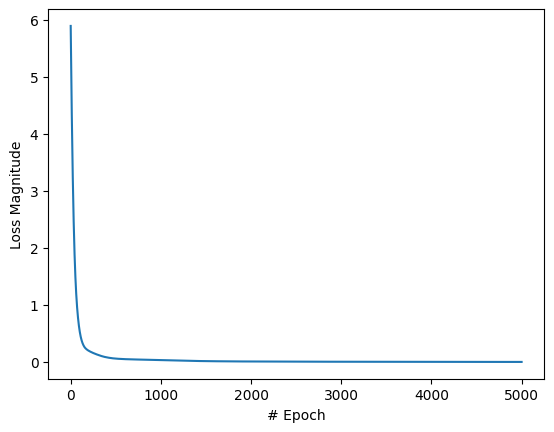

In [9]:
for f in families_arr:
    f.test_loss()
    f.show_loss()

In [10]:
y, x = 1, 1

for i in range(4):
    posibilidades = []

    test_input = torch.tensor([[float(y), float(x), float(i)]], dtype=torch.float32)
    
    print("Input: " + str([y, x, i]))

    for i in range(len(families_arr)):
        resultado = families_arr[i].model(test_input)
        resultado = resultado.detach().numpy()
        posibilidades.append([round(resultado[0][0]), round(resultado[0][1])])
    
    print("Estados futuros predichos: " + str(posibilidades))

    #Calculo el porcentaje de veces que aparece cada posibilidad
    probability_dict = {str(posibilidades.count(p)/len(posibilidades)*100) + "%": p for p in posibilidades}

    probability_dict = {}
    for p in posibilidades:
        if not str(p) in probability_dict:
            probability_dict[str(p)] = str(posibilidades.count(p)/len(posibilidades))


    print("Probabilidades: ")
    for p in probability_dict:
        print(p + ": " + probability_dict[p])

    #print("Probabilidad " + str(p) + ": " + str(posibilidades.count(p)/len(posibilidades)*100) + "%")
    
    print("--------------------------------------------------\n")

Input: [1, 1, 0]
Estados futuros predichos: [[0, 1], [0, 1], [0, 1], [1, 2], [0, 1], [1, 1], [0, 1], [0, 2], [0, 1]]
Probabilidades: 
[0, 1]: 0.6666666666666666
[1, 2]: 0.1111111111111111
[1, 1]: 0.1111111111111111
[0, 2]: 0.1111111111111111
--------------------------------------------------

Input: [1, 1, 1]
Estados futuros predichos: [[1, 0], [2, 0], [2, 1], [2, 1], [2, 1], [1, 1], [2, 1], [2, 1], [2, 1]]
Probabilidades: 
[1, 0]: 0.1111111111111111
[2, 0]: 0.1111111111111111
[2, 1]: 0.6666666666666666
[1, 1]: 0.1111111111111111
--------------------------------------------------

Input: [1, 1, 2]
Estados futuros predichos: [[1, 1], [1, 0], [2, 2], [1, 1], [1, 0], [1, 0], [2, 2], [1, 0], [1, 1]]
Probabilidades: 
[1, 1]: 0.3333333333333333
[1, 0]: 0.4444444444444444
[2, 2]: 0.2222222222222222
--------------------------------------------------

Input: [1, 1, 3]
Estados futuros predichos: [[1, 3], [1, 2], [0, 2], [1, 1], [1, 0], [1, 1], [1, 2], [1, 1], [1, 2]]
Probabilidades: 
[1, 3]: 0.1